# Business Network Study

In this notebook, I look for ways to simplify the current cleaned network with multiple edge types into a network of a single canonical edge-type, or perhaps a network with only a few edge types.

In [40]:
#imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

#constants
%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 5

Let us load in ``../data/processed/cleanedNetwork.pkl`` for creating the does business with network. This requires careful reduction and simplification in node types and edge types.

In [22]:
complicatedNet = nx.read_gpickle("../data/processed/cleanedNetwork.pkl")

In [23]:
#get some quick metrics on this network
numNodes = len(complicatedNet.nodes())
numEdges = len(complicatedNet.edges())

We see that there are {{numNodes}} nodes and {{numEdges}} edges in this network. Note that this network is currently directed, and thus represent a set of directed relationships. This network also contains 4 different types of agents, as outlined in the [ICIJ terms and definitions section for the Offshore Leaks Database](https://offshoreleaks.icij.org/pages/about#terms_definition). Given the many different types of agents and relationships presented in this network, we need to spend some time finding how we can simplify this network.

The key components we are interested in for our analysis is:

* Agents that represent meaningful stakeholders. This means that we should really be considering those people who are financially obligated in the network, and remove agents (such as addresses) that don't represent meaningful financial actors.

* We should remove relationships that do not involve fiscal or business-wise obligations. Given that we are interested in the social capital created by the use of tax havens in the Global 1%, it is essential that we capture relationships that create the social capital involved in dealings with tax havens. This means relationships that do not represent fiscal or business-wise obligations will not have relevance when defining social capital within this network.

* We should look to simplify most of these relationships into simple categories. In order to allow for strong interpretability of the metrics on our analysis, having one or two simple relationships can help us with achieving this goal.

Let us begin our reductions and simplifications on this network.

## Node Reduction

As discussed in our [Initial Analysis Notebook](initialAnalysis.ipynb), close to 15% of the nodes in this network are addresses (see Initial Analysis Notebook, Figure 1). I would argue that these nodes do not represent financial actors and are more focused on locational paper trails. That being said, before we remove them, Let us see the kind of relationships associated with edges coming from address nodes and edges going to address nodes.

In [24]:
#get edges from addresses
fromAddressEdgeList = []
toAddressEdgeList = []
for edge in complicatedNet.edges(data = True):
    #get from and to nodes
    fromNode = edge[0]
    toNode = edge[1]
    #then get information on those nodes
    fromNodeType = complicatedNet.node[fromNode]["entType"]
    toNodeType = complicatedNet.node[toNode]["entType"]
    #check type
    if (fromNodeType == "Addresses"):
        fromAddressEdgeList.append(edge)
    if (toNodeType == "Addresses"):
        toAddressEdgeList.append(edge)

In [25]:
#function to get edge category frames
#taken from initialAnalysis.ipynb
def getEdgeInfo(edgeVec,keyName):
    #helper for returning a list of edge information over the whole list of
    #edges
    edgeInfoDict = {"edgeID":[],keyName:[]}
    for edgeTup in edgeVec:
        #0th entry is ID
        edgeInfoDict["edgeID"].append(edgeTup[0])
        #then get key info
        givenEdgeDict = edgeTup[2]
        edgeInfoDict[keyName].append(givenEdgeDict[keyName])
    return edgeInfoDict
#then get our edge type frames
fromAddressEdgeTypeFrame = pd.DataFrame(getEdgeInfo(fromAddressEdgeList,
                                                    "reltype"))
toAddressEdgeTypeFrame = pd.DataFrame(getEdgeInfo(toAddressEdgeList,"reltype"))
#then get their address type count frames
fromAddressEdgeTypeCountFrame = fromAddressEdgeTypeFrame.groupby("reltype",
                                            as_index = False)["edgeID"].count()
toAddressEdgeTypeCountFrame = toAddressEdgeTypeFrame.groupby("reltype",
                                            as_index = False)["edgeID"].count()
#then format those tables for viewing
fromAddressEdgeTypeCountFrame = fromAddressEdgeTypeCountFrame.rename(columns =
                                                {"reltype":"Edge Type",
                                                 "edgeID":"Count"})
toAddressEdgeTypeCountFrame = toAddressEdgeTypeCountFrame.rename(columns = {
                                                "reltype":"Edge Type",
                                                "edgeID":"Count"})
#then display
display(HTML(fromAddressEdgeTypeCountFrame.to_html(index = False)))

Edge Type,Count
same address as,965


_Table 1: Edge type distribution for edges coming from addresses._

In [26]:
display(HTML(toAddressEdgeTypeCountFrame.to_html(index = False)))

Edge Type,Count
registered address,317029
same address as,965


_Table 2: Edge type distribution for edges going to addresses._

We see that addresses carry very little meaning, as most edges going to addresses simply represent registered addresses of other agents in our network, and all edges coming from networks are simply disambiguation measures ("same address as"). If we were interested in performing a full disambiguation on this network, some of these measures may be meaningful for studying potential paper trails between unlikely agents. However, because disambiguation is out of the scope of this current project, it seems even more reasonable to remove addresses from the network.

In [33]:
#remove addresses
addressList = []
for node in complicatedNet.nodes(data = True):
    if (node[1]["entType"] == "Addresses"):
        addressList.append(node[0])
#then remove
complicatedNet.remove_nodes_from(addressList)

In [37]:
#just a check on the number of nodes and edges now in the network
newNumNodes = len(complicatedNet.nodes())
newNumEdges = len(complicatedNet.edges())
#get percent reduction
percentMul = 100
percentReductionInNodes = (float(numNodes - newNumNodes)/numNodes) * percentMul
percentReductionInEdges = (float(numEdges - newNumEdges)/numEdges) * percentMul

We see that the new number of nodes and the new number of edges after the reduction are both {{newNumNodes}} and {{newNumEdges}}. This node reduction reduced the number of nodes in our network by {{percentReductionInNodes}}% and reduced the number of edges in our network by {{percentReductionInEdges}}%. These are sizable reduction, but this in essence gives us  a much easier network to work with.

Let us look at our agent type distribution after this reduction. Most of the code below is taken [from my initial analysis notebook](initialAnalysis.ipynb).

In [38]:
#get information by category on nodes
#code taken from initialAnalysis.ipynb
def getNodeInfo(nodeVec,keyName):
    #helper for returning a list of node information over the whole list of
    #nodes
    nodeInfoDict = {"nodeID":[],keyName:[]}
    for nodeTup in nodeVec:
        #0th entry is ID
        nodeInfoDict["nodeID"].append(nodeTup[0])
        #then get key info
        givenNodeDict = nodeTup[1]
        nodeInfoDict[keyName].append(givenNodeDict[keyName])
    return nodeInfoDict
#then make data frame of information
nodeVec = complicatedNet.nodes(data = True)
nodeEntFrame = pd.DataFrame(getNodeInfo(nodeVec,"entType"))

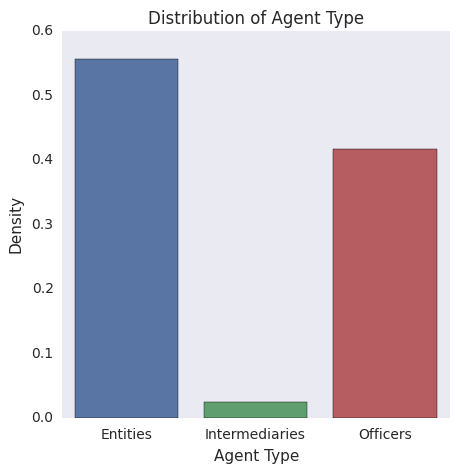

In [41]:
#then get entity distribution
entCountFrame = nodeEntFrame.groupby("entType",
                                     as_index = False)["nodeID"].count()
entCountFrame = entCountFrame.rename(columns = {"nodeID":"count"})
entCountFrame["density"] = entCountFrame["count"] / sum(entCountFrame["count"])
#then plot
givenFig = plt.figure(figsize = (figWidth,figHeight))
sns.barplot(x = "entType",y = "density",data = entCountFrame)
plt.xlabel("Agent Type")
plt.ylabel("Density")
plt.title("Distribution of Agent Type")

_Figure 1: Distribution of Agent Type on the network after our node reduction._

We see that entities make up a large portion of the agent type distribution, with officers coming a close second. Again, intermediaries represent an extremely small part of the network, but it is likely that even after our edge reduction and simplifications that intermediaries will still have extremely high degree in this network.